## Bibliotheque


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data from drive
### connect to drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load folders

In [ ]:
import shutil

folder_path = '/content/drive/MyDrive/Alegumes'
destination_path = 'legumes/'

shutil.copytree(folder_path, destination_path)

'legumes/'

Now we have a legumes folder which contain ten subfolders, Each subfolder contains image files for each category.

In [ ]:
!ls legumes

ail	   carotte    fenouil  onion   poivre
aubergine  courgette  laitue   patate  tomate


## Generate a `Dataset`

In [ ]:
image_size = (64, 64)
batch_size = 8

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "legumes",
    validation_split=0.2, # 20% des images pour la validation
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,

)



Found 547 files belonging to 10 classes.
Using 438 files for training.
Using 109 files for validation.


Visualize the data
Here are the first 9 images in the training dataset

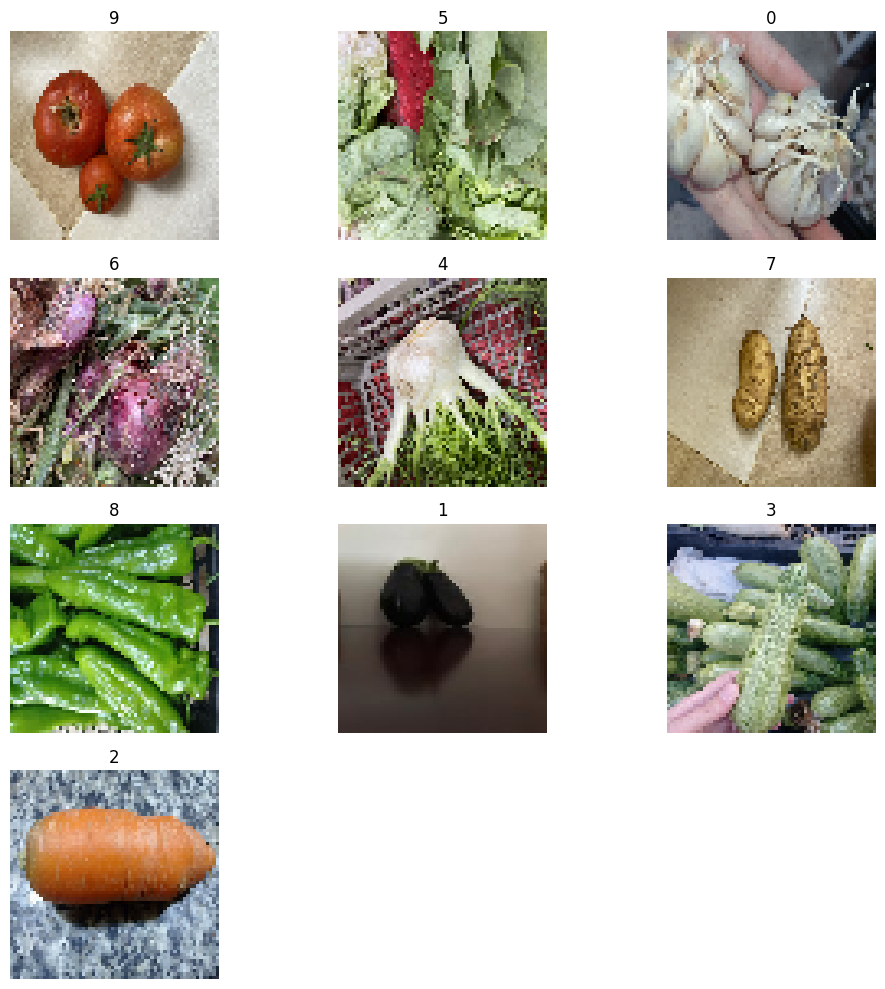

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
class_images = []

for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_label = int(label)
        if class_label not in class_images:
            class_images.append(class_label)
            ax = plt.subplot(4, 3, len(class_images))
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(class_label)
            plt.axis("off")

    if len(class_images) == 12:  # Modify the condition to match the desired number of images (12 for a 4x3 grid)
        break

plt.tight_layout()
plt.show()


Using image data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(0.1),
    ]
)


Configure the dataset for performance

In [ ]:
# Apply `data_augmentation` to the training images.

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
num_train_samples = tf.data.experimental.cardinality(train_ds).numpy()
print("Number of samples in train_ds:", num_train_samples)



Number of samples in train_ds: 27


## Build a model

In [ ]:
def make_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model




## Training

In [ ]:
num_classes = 10
epochs = 6

# Create the model
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/6
55/55 [==============================] - 44s 612ms/step - loss: 12.6269 - accuracy: 0.2808 - val_loss: 1.4580 - val_accuracy: 0.4679
Epoch 2/6
55/55 [==============================] - 41s 654ms/step - loss: 1.4402 - accuracy: 0.5114 - val_loss: 0.9335 - val_accuracy: 0.6147
Epoch 3/6
55/55 [==============================] - 40s 673ms/step - loss: 1.3025 - accuracy: 0.6096 - val_loss: 1.1943 - val_accuracy: 0.5596
Epoch 4/6
55/55 [==============================] - 39s 671ms/step - loss: 1.1312 - accuracy: 0.6233 - val_loss: 0.8146 - val_accuracy: 0.7523
Epoch 5/6
55/55 [==============================] - 39s 669ms/step - loss: 0.7506 - accuracy: 0.7648 - val_loss: 0.5080 - val_accuracy: 0.8165
Epoch 6/6
55/55 [==============================] - 39s 660ms/step - loss: 0.7827 - accuracy: 0.7283 - val_loss: 0.5040 - val_accuracy: 0.8257


In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(val_ds)

14/14 [==============================] - 8s 575ms/step - loss: 0.5040 - accuracy: 0.8257


1/1 [==============================] - 0s 25ms/step


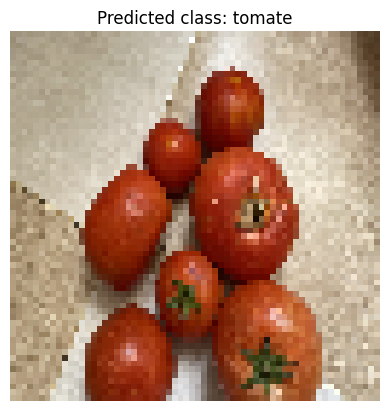

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

class_names = ["ail", "aubergine", "carotte", "courgette", "fenouil", "laitue", "onion", "batate", "poivre","tomate"]

# Load and preprocess the image
img = keras.utils.load_img("/content/legumes/tomate/IMG_3067.JPG", target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)
img_array = img_array  # Normalize the image

# Make predictions
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]

# Display the image
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted class: {predicted_class}")
plt.show()

